# Doing it in VS code first. Since terminal etc ki requirement hai hosting etc krne ke liye. Bad me jupyter notebook will be merged.

Directory structure :

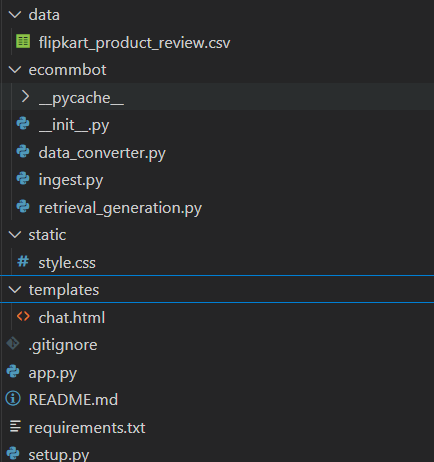

# data converter . py

In [ ]:

import pandas as pd
from langchain_core.documents import Document


def dataconveter():
    product_data=pd.read_csv("C:\\Users\\prabh\\srijan\\eCommerce chatboot\\data\\flipkart_product_review.csv")

    data=product_data[["product_title","review"]]

    product_list = []

    # Iterate over the rows of the DataFrame
    for index, row in data.iterrows():
        # Construct an object with 'product_name' and 'review' attributes
        obj = {
                'product_name': row['product_title'],
                'review': row['review']
            }
        # Append the object to the list
        product_list.append(obj)

    # print(product_data)

    docs = []
    for entry in product_list:
        metadata = {"product_name": entry['product_name']}
        doc = Document(page_content=entry['review'], metadata=metadata)
        docs.append(doc)
    return docs



# ingest . py

In [ ]:
from langchain_astradb import AstraDBVectorStore
# from langchain_openai import OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
import os
import pandas as pd
from data_converter import dataconveter

load_dotenv()

# OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")
ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_KEYSPACE = os.getenv("ASTRA_DB_KEYSPACE")

# embedding = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", api_key = GEMINI_API_KEY)

def ingestdata(status):
    vstore = AstraDBVectorStore(
            embedding = embeddings,
            collection_name = "chatbotecomm",
            api_endpoint = ASTRA_DB_API_ENDPOINT,
            token = ASTRA_DB_APPLICATION_TOKEN,
            namespace = ASTRA_DB_KEYSPACE,
        )

    storage=status

    if storage==None:
        docs=dataconveter()
        inserted_ids = vstore.add_documents(docs)
    else:
        return vstore
    return vstore, inserted_ids

if __name__=='__main__':
    vstore,inserted_ids=ingestdata(None)
    print(f"\nInserted {len(inserted_ids)} documents.")
    results = vstore.similarity_search("can you tell me the low budget sound basshead.")
    for res in results:
            print(f"* {res.page_content} [{res.metadata}]")

# retrieval generation . py

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
# from langchain_openai import ChatOpenAI
from langchain_google_genai import GoogleGenerativeAI
from ingest import ingestdata
import os

GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")

def generation(vstore):
    retriever = vstore.as_retriever(search_kwargs={"k": 3})

    PRODUCT_BOT_TEMPLATE = """
    Your ecommercebot bot is an expert in product recommendations and customer queries.
    It analyzes product titles and reviews to provide accurate and helpful responses.
    Ensure your answers are relevant to the product context and refrain from straying off-topic.
    Your responses should be concise and informative.

    CONTEXT:
    {context}

    QUESTION: {question}

    YOUR ANSWER:

    """


    prompt = ChatPromptTemplate.from_template(PRODUCT_BOT_TEMPLATE)

    # llm = ChatOpenAI()
    llm = GoogleGenerativeAI(model="models/gemini-2.0-flash-exp", google_api_key=GEMINI_API_KEY)

    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    return chain

if __name__=='__main__':
    vstore = ingestdata("done")
    chain  = generation(vstore)
    print(chain.invoke("can you tell me the best bluetooth buds?"))



# app.py

In [ ]:
from flask import Flask, render_template, jsonify, request
from dotenv import load_dotenv
import os
from ecommbot.retrieval_generation import generation
from ecommbot.ingest import ingestdata

app = Flask(__name__)

load_dotenv()

vstore = ingestdata("done")
chain = generation(vstore)

@app.route("/")
def index():
    return render_template('chat.html')

@app.route("/get", methods=["GET", "POST"])
def chat():
    msg = request.form["msg"]
    input = msg
    result=chain.invoke(input)
    print("Response : ", result)
    return str(result)

if __name__ == '__main__':
    app.run(debug= True)

# App is ready few visuals :

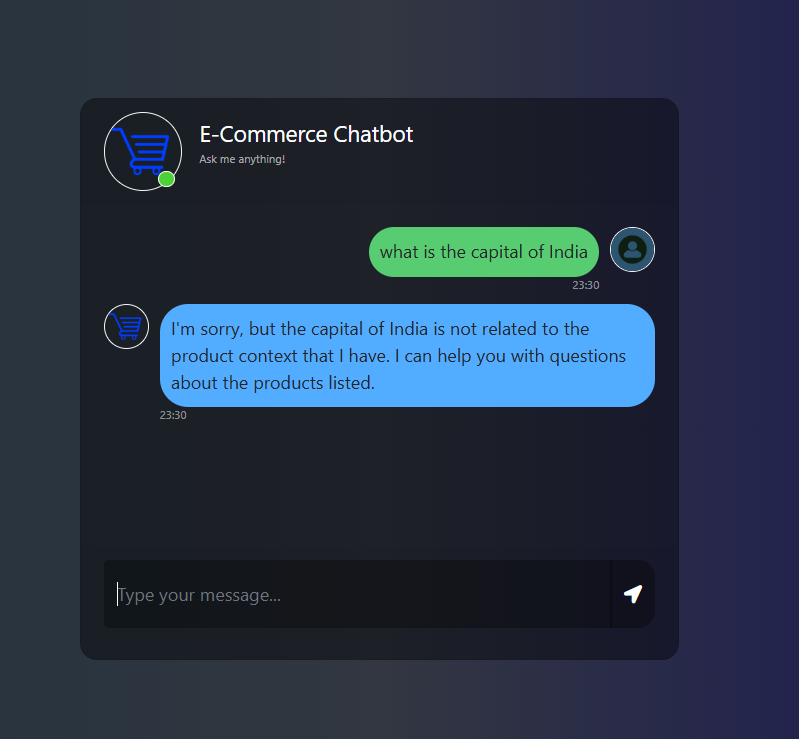

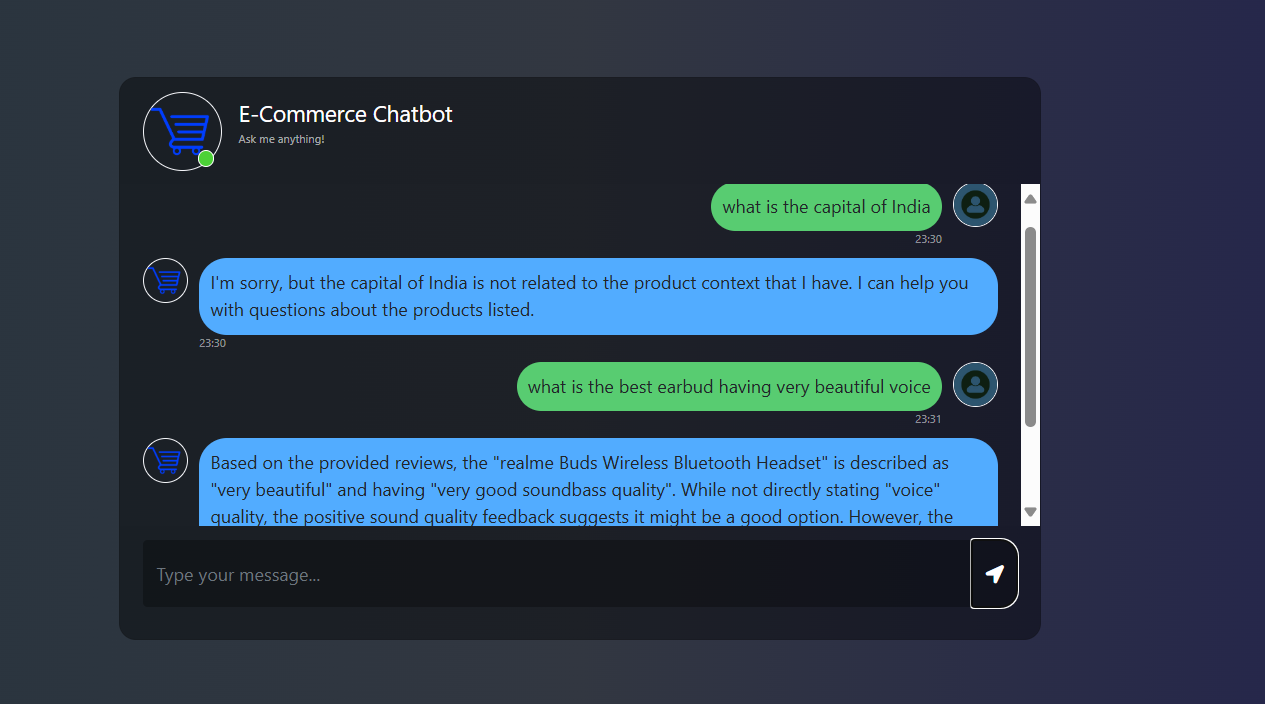

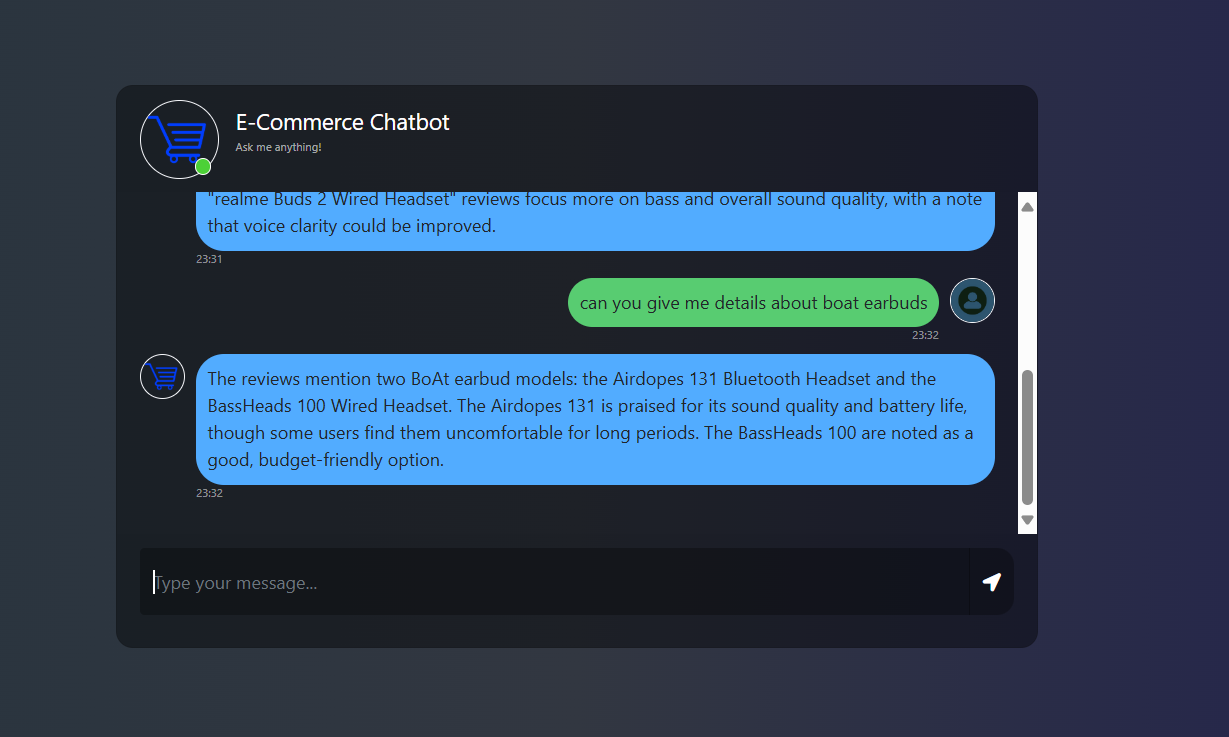

#Now deploying it on AWS

# I built and deployed on AWS. Kya bat hai I used first time AWS, got to know 12 month free deta hai. Previous project me I used first time google cloud, got to know 90 days free trial in google cloud. First time I used Flask().